In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [17]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models
from PIL import Image
import time
import random
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as ssim
from tqdm.notebook import tqdm
import glob

In [18]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Define dataset paths (adjust according to your Kaggle setup)
TRAIN_HAZY_PATH = "/kaggle/input/reside-6k/RESIDE-6K/train/hazy"
TRAIN_GT_PATH = "/kaggle/input/reside-6k/RESIDE-6K/train/GT"
TEST_HAZY_PATH = "/kaggle/input/reside-6k/RESIDE-6K/test/hazy"
TEST_GT_PATH = "/kaggle/input/reside-6k/RESIDE-6K/test/GT"

Using device: cuda


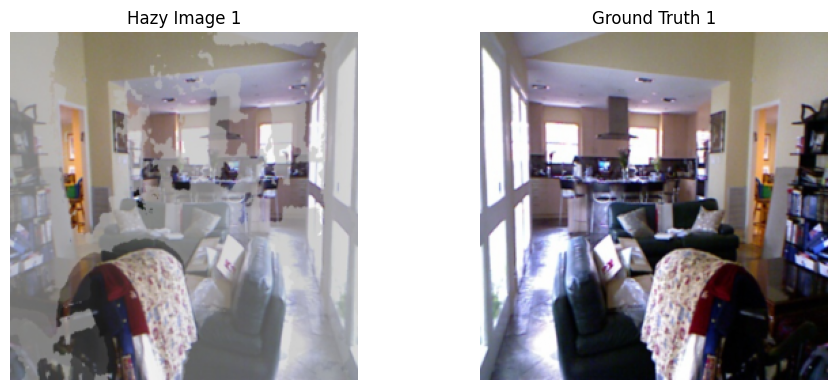

Displayed 1 out of 1 requested samples (batch size: 1)


In [19]:
# Create custom Dataset class
class DehazeDataset(Dataset):
    def __init__(self, hazy_dir, gt_dir, transform=None, is_test=False):
        """
        Args:
            hazy_dir (string): Directory with hazy images
            gt_dir (string): Directory with ground truth images
            transform (callable, optional): Optional transform to be applied on a sample
            is_test (bool): Whether this is a test dataset (no resizing for test)
        """
        self.hazy_dir = hazy_dir
        self.gt_dir = gt_dir
        self.transform = transform
        self.is_test = is_test
        
        # Get all image pairs
        self.hazy_files = sorted(glob.glob(os.path.join(hazy_dir, "*.jpg")))
        self.gt_files = sorted(glob.glob(os.path.join(gt_dir, "*.jpg")))
        
        # Ensure equal number of files
        assert len(self.hazy_files) == len(self.gt_files), "Mismatch in number of hazy and GT images"
        
    def __len__(self):
        return len(self.hazy_files)
    
    def __getitem__(self, idx):
        # Load images
        hazy_img = Image.open(self.hazy_files[idx]).convert('RGB')
        gt_img = Image.open(self.gt_files[idx]).convert('RGB')
        
        # Apply transformations
        if self.transform:
            hazy_img = self.transform(hazy_img)
            gt_img = self.transform(gt_img)
        
        # Normalize to [-1, 1] range
        hazy_img = (hazy_img * 2) - 1
        gt_img = (gt_img * 2) - 1
        
        return {'hazy': hazy_img, 'gt': gt_img, 'filename': os.path.basename(self.hazy_files[idx])}

# Define data transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to model input size
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor()  # Convert to tensor and normalize to [0, 1]
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize for consistent evaluation
    transforms.ToTensor()  # Convert to tensor and normalize to [0, 1]
])

# Create datasets
train_dataset = DehazeDataset(TRAIN_HAZY_PATH, TRAIN_GT_PATH, transform=train_transform)
test_dataset = DehazeDataset(TEST_HAZY_PATH, TEST_GT_PATH, transform=test_transform, is_test=True)

# Create dataloaders
BATCH_SIZE = 1  # As specified in the original code
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

# Visualize some training samples
def visualize_samples(dataloader, num_samples=BATCH_SIZE):
    samples = next(iter(dataloader))
    hazy_images = samples['hazy']
    gt_images = samples['gt']
    
    # Determine actual number of images to display (minimum of batch size and requested samples)
    actual_samples = min(len(hazy_images), num_samples)
    
    # If no samples available, notify and return
    if actual_samples == 0:
        print("No samples available to visualize.")
        return
    
    # Create figure with appropriate dimensions
    fig, axes = plt.subplots(actual_samples, 2, figsize=(10, actual_samples*4))
    
    # Handle case where only one sample is displayed (axes won't be 2D)
    if actual_samples == 1:
        axes = np.array([axes])
    
    for i in range(actual_samples):
        # Convert tensors back to [0, 1] range for visualization
        hazy = (hazy_images[i] + 1) / 2
        gt = (gt_images[i] + 1) / 2
        
        # Move channel dimension to the end for plotting
        hazy = hazy.permute(1, 2, 0).cpu().numpy()
        gt = gt.permute(1, 2, 0).cpu().numpy()
        
        # Plot images
        axes[i, 0].imshow(hazy)
        axes[i, 0].set_title(f"Hazy Image {i+1}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(gt)
        axes[i, 1].set_title(f"Ground Truth {i+1}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print information about the visualization
    print(f"Displayed {actual_samples} out of {num_samples} requested samples (batch size: {len(hazy_images)})")

# Uncomment to visualize
visualize_samples(train_dataloader)

In [21]:
# Define model components

# Tiramisu (FC-DenseNet) components
class CompositeLayer(nn.Module):
    def __init__(self, in_channels, growth_rate, dropout_rate=0.2):
        super(CompositeLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1)
        self.dropout = nn.Dropout2d(dropout_rate)
        
    def forward(self, x):
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.dropout(x)
        return x

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, layers=4):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        self.growth_rate = growth_rate

        for i in range(layers):
            self.layers.append(CompositeLayer(in_channels + i * growth_rate, growth_rate))

    def forward(self, x):
        features = [x]
        current_input = x
        
        for i, layer in enumerate(self.layers):
            # Process the current concatenated input through the layer
            new_features = layer(current_input)
            # Add the new features to our list
            features.append(new_features)
            # Concatenate all features for the next layer's input
            current_input = torch.cat(features, dim=1)
            
            # Optional debugging print (you can remove this if not needed)
            #print(f"DenseBlock Layer {i}: Input shape {x.shape}, Output shape {current_input.shape}")
            
        return current_input  # Return the final concatenated features



class TransitionDown(nn.Module):
    def __init__(self, in_channels, reduction=0.5, dropout_rate=0.2):
        super(TransitionDown, self).__init__()
        out_channels = int(in_channels * reduction)
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.dropout = nn.Dropout2d(dropout_rate)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.bn(x)
        x = self.conv(x)
        x = self.dropout(x)
        x = self.pool(x)
        return x

class TransitionUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionUp, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, 
                                         kernel_size=3, stride=2, padding=1, output_padding=1)
        
    def forward(self, x):
        x = self.deconv(x)
        return x

# Generator (Tiramisu 56-layer)
# Modified Model Architecture (replace the existing TiramisuGenerator class)
class TiramisuGenerator(nn.Module):
    def __init__(self, in_channels=3, growth_rate=16, layers_per_block=4):
        super(TiramisuGenerator, self).__init__()
        # Initial convolution with more filters
        self.input_conv = nn.Conv2d(in_channels, growth_rate*6, kernel_size=3, padding=1)
        
        # Encoder path with more capacity
        self.encoder_blocks = nn.ModuleList()
        self.transition_downs = nn.ModuleList()
        num_encoder_blocks = 5
        in_ch = growth_rate * 6
        skip_connection_channels = []
        
        for i in range(num_encoder_blocks):
            self.encoder_blocks.append(DenseBlock(in_ch, growth_rate, layers=layers_per_block))
            in_ch += growth_rate * layers_per_block
            skip_connection_channels.append(in_ch)
            self.transition_downs.append(TransitionDown(in_ch, reduction=0.6))  # Less aggressive reduction
            in_ch = int(in_ch * 0.6)
        
        # Bottleneck with more layers
        self.bottleneck = DenseBlock(in_ch, growth_rate, layers=18)
        in_ch += growth_rate * 18
        
        # Decoder path with more capacity
        self.decoder_blocks = nn.ModuleList()
        self.transition_ups = nn.ModuleList()
        
        for i in range(num_encoder_blocks):
            self.transition_ups.append(TransitionUp(in_ch, in_ch // 2))
            in_ch = in_ch // 2
            in_ch += skip_connection_channels[-(i+1)]
            self.decoder_blocks.append(DenseBlock(in_ch, growth_rate, layers=layers_per_block))
            in_ch += growth_rate * layers_per_block
        
        # Output convolution
        self.output_conv = nn.Sequential(
            nn.Conv2d(in_ch, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=1)
        )
        
    def forward(self, x):
        # Initial convolution
        x = self.input_conv(x)
        
        # Encoder path
        skip_connections = []
        for i, (encoder, td) in enumerate(zip(self.encoder_blocks, self.transition_downs)):
            x = encoder(x)
            skip_connections.append(x)
            x = td(x)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder path
        for i, (tu, decoder) in enumerate(zip(self.transition_ups, self.decoder_blocks)):
            x = tu(x)
            skip = skip_connections[-(i+1)]
            x = torch.cat([x, skip], dim=1)
            x = decoder(x)
        
        # Output convolution
        x = self.output_conv(x)
        return torch.tanh(x)

# PatchGAN Discriminator
class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=6, ndf=64):
        super(PatchGANDiscriminator, self).__init__()
        
        # Layer 1: No normalization
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Layer 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Layer 4
        self.layer4 = nn.Sequential(
            nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Final layer
        self.final = nn.Sequential(
            nn.Conv2d(ndf*8, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, hazy, target):
        # Concat input and target
        x = torch.cat([hazy, target], dim=1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.final(x)
        return x

# VGG19 for perceptual loss
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19, VGG19_Weights  # ✅ Import vgg19 & weights

class VGG19FeatureExtractor(nn.Module):
    def __init__(self):
        super(VGG19FeatureExtractor, self).__init__()

        # ✅ Use weights correctly, with a fallback for older PyTorch versions
        try:
            vgg = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)  # Newer versions
        except AttributeError:
            vgg = vgg19(pretrained=True)  # Fallback for older versions

        self.feature_extractor = nn.Sequential(*list(vgg.features.children())[:25])

        # Freeze the parameters to prevent updates during training
        for param in self.parameters():
            param.requires_grad = False
    
    def forward(self, img):
        # Resize to 224x224 for VGG
        img = F.interpolate(img, size=(224, 224), mode='bilinear', align_corners=False)

        # Normalize image (from [-1,1] to [0,1])
        img = (img + 1) / 2

        # Apply VGG normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(img.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(img.device)
        img = (img - mean) / std

        return self.feature_extractor(img)


# Define loss functions
class GANLoss(nn.Module):
    def __init__(self, real_label=1.0, fake_label=0.0):
        super(GANLoss, self).__init__()
        self.real_label = real_label
        self.fake_label = fake_label
        self.eps = 1e-12
        
    def __call__(self, prediction, target_is_real):
        if target_is_real:
            target = torch.ones_like(prediction)
            loss = -torch.mean(torch.log(prediction + self.eps))
        else:
            target = torch.zeros_like(prediction)
            loss = -torch.mean(torch.log(1 - prediction + self.eps))
        return loss

# Modified DehazeGAN class initialization
class DehazeGAN:
    def __init__(self):
        # Modified model parameters
        self.gen_filters = 64
        self.disc_filters = 64
        self.layers = 4
        self.growth_rate = 16  # Increased from 12
        self.gan_wt = 1.0     # Reduced from 2
        self.l1_wt = 120      # Increased from 100
        self.vgg_wt = 15      # Increased from 10
        self.batch_sz = 1
        self.epochs = 4
        self.lr = 0.0002      # Reduced from 0.001
        
        # Initialize models
        self.generator = TiramisuGenerator(in_channels=3, growth_rate=self.growth_rate, 
                                          layers_per_block=self.layers).to(device)
        self.discriminator = PatchGANDiscriminator(in_channels=6, ndf=self.disc_filters).to(device)
        self.vgg = VGG19FeatureExtractor().to(device)
        
        # Initialize loss functions
        self.gan_loss = GANLoss()
        self.l1_loss = nn.L1Loss()
        
        # Initialize optimizers with different betas
        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=self.lr, betas=(0.5, 0.999))
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=self.lr*0.5, betas=(0.5, 0.999))
        
        # For logging
        self.train_losses = {'g_total': [], 'g_gan': [], 'g_l1': [], 'g_vgg': [], 'd_loss': []}
        self.val_metrics = {'psnr': [], 'ssim': [], 'score': []}
        
        # Add learning rate schedulers
        self.g_scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.g_optimizer, 'min', factor=0.5, patience=2)
        self.d_scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.d_optimizer, 'min', factor=0.5, patience=2)
        
# Modified train method for DehazeGAN class
    def train(self, train_dataloader, val_dataloader, epochs=None, save_dir='./models'):
        if epochs is None:
            epochs = self.epochs
        
        # Create directory for saving models
        os.makedirs(save_dir, exist_ok=True)
        best_score = -1
        
        for epoch in range(epochs):
            start_time = time.time()
            
            # Training loop
            self.generator.train()
            self.discriminator.train()
            running_g_loss = 0.0
            running_d_loss = 0.0
            running_gan_loss = 0.0
            running_l1_loss = 0.0
            running_vgg_loss = 0.0
            
            for sample in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
                hazy = sample['hazy'].to(device)
                gt = sample['gt'].to(device)
                
                # Train discriminator (with frequency control)
                if epoch < 3 or np.random.random() < 0.8:  # Train D less frequently after initial epochs
                    self.d_optimizer.zero_grad()
                    
                    # Real pair
                    real_pair_pred = self.discriminator(hazy, gt)
                    d_real_loss = self.gan_loss(real_pair_pred, True)
                    
                    # Generate fake image
                    fake_image = self.generator(hazy)
                    
                    # Fake pair
                    fake_pair_pred = self.discriminator(hazy, fake_image.detach())
                    d_fake_loss = self.gan_loss(fake_pair_pred, False)
                    
                    # Total discriminator loss with gradient clipping
                    d_loss = (d_real_loss + d_fake_loss) / 2
                    d_loss.backward()
                    
                    # Apply gradient clipping to prevent exploding gradients
                    torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), max_norm=1.0)
                    
                    self.d_optimizer.step()
                else:
                    d_loss = torch.tensor(0.0).to(device)
                
                # Train generator
                self.g_optimizer.zero_grad()
                
                # Generate fake image
                fake_image = self.generator(hazy)
                
                # GAN loss
                fake_pair_pred = self.discriminator(hazy, fake_image)
                g_gan_loss = self.gan_loss(fake_pair_pred, True)
                
                # L1 loss
                g_l1_loss = self.l1_loss(fake_image, gt)
                
                # VGG perceptual loss
                vgg_gt = self.vgg(gt)
                vgg_fake = self.vgg(fake_image)
                g_vgg_loss = 1e-4 * F.mse_loss(vgg_fake, vgg_gt)  # Increased weight
                
                # Total generator loss
                g_loss = self.gan_wt * g_gan_loss + self.l1_wt * g_l1_loss + self.vgg_wt * g_vgg_loss
                g_loss.backward()
                
                # Apply gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(self.generator.parameters(), max_norm=1.0)
                
                self.g_optimizer.step()
                
                # Update running losses
                running_d_loss += d_loss.item()
                running_g_loss += g_loss.item()
                running_gan_loss += g_gan_loss.item() * self.gan_wt
                running_l1_loss += g_l1_loss.item() * self.l1_wt
                running_vgg_loss += g_vgg_loss.item() * self.vgg_wt
            
            # Calculate average losses for the epoch
            avg_d_loss = running_d_loss / len(train_dataloader)
            avg_g_loss = running_g_loss / len(train_dataloader)
            avg_gan_loss = running_gan_loss / len(train_dataloader)
            avg_l1_loss = running_l1_loss / len(train_dataloader)
            avg_vgg_loss = running_vgg_loss / len(train_dataloader)
            
            # Log losses
            self.train_losses['d_loss'].append(avg_d_loss)
            self.train_losses['g_total'].append(avg_g_loss)
            self.train_losses['g_gan'].append(avg_gan_loss)
            self.train_losses['g_l1'].append(avg_l1_loss)
            self.train_losses['g_vgg'].append(avg_vgg_loss)
            
            # Validation
            if epoch % 2 == 0 or epoch == epochs - 1:  # Validate every 2 epochs instead of 5
                avg_psnr, avg_ssim, score = self.validate(val_dataloader)
                self.val_metrics['psnr'].append(avg_psnr)
                self.val_metrics['ssim'].append(avg_ssim)
                self.val_metrics['score'].append(score)
                
                # Update learning rate schedulers
                self.g_scheduler.step(avg_g_loss)
                self.d_scheduler.step(avg_d_loss)
                
                # Save best model
                if score > best_score:
                    best_score = score
                    torch.save({
                        'generator_state_dict': self.generator.state_dict(),
                        'discriminator_state_dict': self.discriminator.state_dict(),
                        'g_optimizer_state_dict': self.g_optimizer.state_dict(),
                        'd_optimizer_state_dict': self.d_optimizer.state_dict(),
                        'epoch': epoch,
                        'score': score,
                        'psnr': avg_psnr,
                        'ssim': avg_ssim
                    }, os.path.join(save_dir, 'best_model.pth'))
                
                # Log validation results
                print(f"Validation - PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}, Score: {score:.4f}")
            
            epoch_time = time.time() - start_time
            
            # Print epoch summary
            print(f"Epoch {epoch+1}/{epochs} completed in {epoch_time:.2f}s")
            print(f"D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}")
            print(f"G GAN Loss: {avg_gan_loss:.4f}, G L1 Loss: {avg_l1_loss:.4f}, G VGG Loss: {avg_vgg_loss:.4f}")
            
            # Save checkpoint periodically
            if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
                torch.save({
                    'generator_state_dict': self.generator.state_dict(),
                    'discriminator_state_dict': self.discriminator.state_dict(),
                    'g_optimizer_state_dict': self.g_optimizer.state_dict(),
                    'd_optimizer_state_dict': self.d_optimizer.state_dict(),
                    'epoch': epoch,
                }, os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'))
        
        # Save final model
        torch.save({
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'g_optimizer_state_dict': self.g_optimizer.state_dict(),
            'd_optimizer_state_dict': self.d_optimizer.state_dict(),
            'epoch': epochs - 1,
        }, os.path.join(save_dir, 'final_model.pth'))
        
        return self.train_losses, self.val_metrics
    
    def validate(self, val_dataloader):
        self.generator.eval()
        
        total_psnr = 0
        total_ssim = 0
        psnr_weight = 1/20
        ssim_weight = 1
        
        with torch.no_grad():
            for sample in tqdm(val_dataloader, desc="Validating"):
                hazy = sample['hazy'].to(device)
                gt = sample['gt'].to(device)
                
                # Generate dehazed image
                dehazed = self.generator(hazy)
                
                # Convert tensors to numpy for metrics calculation
                dehazed_np = ((dehazed[0] + 1) / 2).clamp(0, 1).cpu().permute(1, 2, 0).numpy()
                gt_np = ((gt[0] + 1) / 2).clamp(0, 1).cpu().permute(1, 2, 0).numpy()
                
                # Check image dimensions for debugging
                h, w, c = dehazed_np.shape
                
                # Calculate metrics with appropriate parameters
                psnr = compare_psnr(gt_np, dehazed_np, data_range=1.0)
                
                # Use smaller window size and specify channel_axis for SSIM
                win_size = min(7, h-1, w-1)
                if win_size % 2 == 0:  # Ensure win_size is odd
                    win_size -= 1
                    
                # Make sure win_size is at least 3
                win_size = max(3, win_size)
                
                ssim_val = ssim(
                    gt_np, 
                    dehazed_np, 
                    data_range=1.0, 
                    channel_axis=2,  # Specify channel axis explicitly
                    win_size=win_size  # Use appropriate window size
                )
                
                total_psnr += psnr
                total_ssim += ssim_val
                
        # Calculate averages
        avg_psnr = total_psnr / len(val_dataloader)
        avg_ssim = total_ssim / len(val_dataloader)
        
        # Calculate score as in the original code
        score = avg_psnr * psnr_weight + avg_ssim * ssim_weight
        
        self.generator.train()
        
        return avg_psnr, avg_ssim, score
    
    def inference(self, test_dataloader, output_dir='./results'):
        """
        Run inference on test data and save results
        """
        os.makedirs(output_dir, exist_ok=True)
        self.generator.eval()
        
        total_psnr = 0
        total_ssim = 0
        psnr_weight = 1/20
        ssim_weight = 1
        
        with torch.no_grad():
            for sample in tqdm(test_dataloader, desc="Inference"):
                hazy = sample['hazy'].to(device)
                gt = sample['gt'].to(device)
                filename = sample['filename'][0]
                
                # Generate dehazed image
                dehazed = self.generator(hazy)
                
                # Save images
                dehazed_img = (dehazed[0].cpu().permute(1, 2, 0).numpy() + 1) / 2
                dehazed_img = (dehazed_img * 255).clip(0, 255).astype(np.uint8)
                plt.imsave(os.path.join(output_dir, f"dehazed_{filename}"), dehazed_img)
                
                # Convert tensors for metrics calculation
                dehazed_np = ((dehazed[0] + 1) / 2).clamp(0, 1).cpu().permute(1, 2, 0).numpy()
                gt_np = ((gt[0] + 1) / 2).clamp(0, 1).cpu().permute(1, 2, 0).numpy()
                
                # Check image dimensions
                h, w, c = dehazed_np.shape
                
                # Calculate PSNR
                psnr = compare_psnr(gt_np, dehazed_np, data_range=1.0)
                
                # Calculate SSIM with appropriate window size
                win_size = min(7, h-1, w-1)
                if win_size % 2 == 0:  # Ensure win_size is odd
                    win_size -= 1
                win_size = max(3, win_size)
                
                ssim_val = ssim(
                    gt_np, 
                    dehazed_np, 
                    data_range=1.0, 
                    channel_axis=2,
                    win_size=win_size
                )
                
                total_psnr += psnr
                total_ssim += ssim_val
                
        # Calculate averages
        avg_psnr = total_psnr / len(test_dataloader)
        avg_ssim = total_ssim / len(test_dataloader)
        score = avg_psnr * psnr_weight + avg_ssim * ssim_weight
        
        print(f"Test Results - PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}, Score: {score:.4f}")
        
        return avg_psnr, avg_ssim, score
    
    def load_checkpoint(self, checkpoint_path):
        """
        Load model checkpoint for inference or continue training
        """
        checkpoint = torch.load(checkpoint_path, map_location=device)
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        self.g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
        self.d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
        
        epoch = checkpoint.get('epoch', -1)
        score = checkpoint.get('score', -1)
        
        print(f"Loaded checkpoint from epoch {epoch+1} with score {score:.4f}")
        
        return epoch
    
    def plot_losses(self):
        """
        Plot training losses
        """
        plt.figure(figsize=(15, 10))
        
        # Plot generator losses
        plt.subplot(2, 1, 1)
        plt.plot(self.train_losses['g_total'], label='G Total Loss')
        plt.plot(self.train_losses['g_gan'], label='G GAN Loss')
        plt.plot(self.train_losses['g_l1'], label='G L1 Loss')
        plt.plot(self.train_losses['g_vgg'], label='G VGG Loss')
        plt.title('Generator Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        # Plot discriminator loss
        plt.subplot(2, 1, 2)
        plt.plot(self.train_losses['d_loss'], label='D Loss')
        plt.title('Discriminator Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('training_losses.png')
        plt.show()
    
    # Fixed plot_metrics function
    def plot_metrics(self):
        """
        Plot validation metrics
        """
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.plot(self.val_metrics['psnr'])
        plt.title('PSNR')
        plt.xlabel('Validation Iteration')
        plt.ylabel('PSNR')
        plt.grid(True)
        
        plt.subplot(1, 3, 2)
        plt.plot(self.val_metrics['ssim'])
        plt.title('SSIM')
        plt.xlabel('Validation Iteration')
        plt.ylabel('SSIM')
        plt.grid(True)
        
        plt.subplot(1, 3, 3)
        plt.plot(self.val_metrics['score'])
        plt.title('Overall Score')
        plt.xlabel('Validation Iteration')
        plt.ylabel('Score')
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('validation_metrics.png')
        plt.show()

In [ ]:
# Initialize and train the model
dehaze_gan = DehazeGAN()
dehaze_gan.train(train_dataloader, test_dataloader)

Epoch 1/4 - Training:   0%|          | 0/6000 [00:00<?, ?it/s]

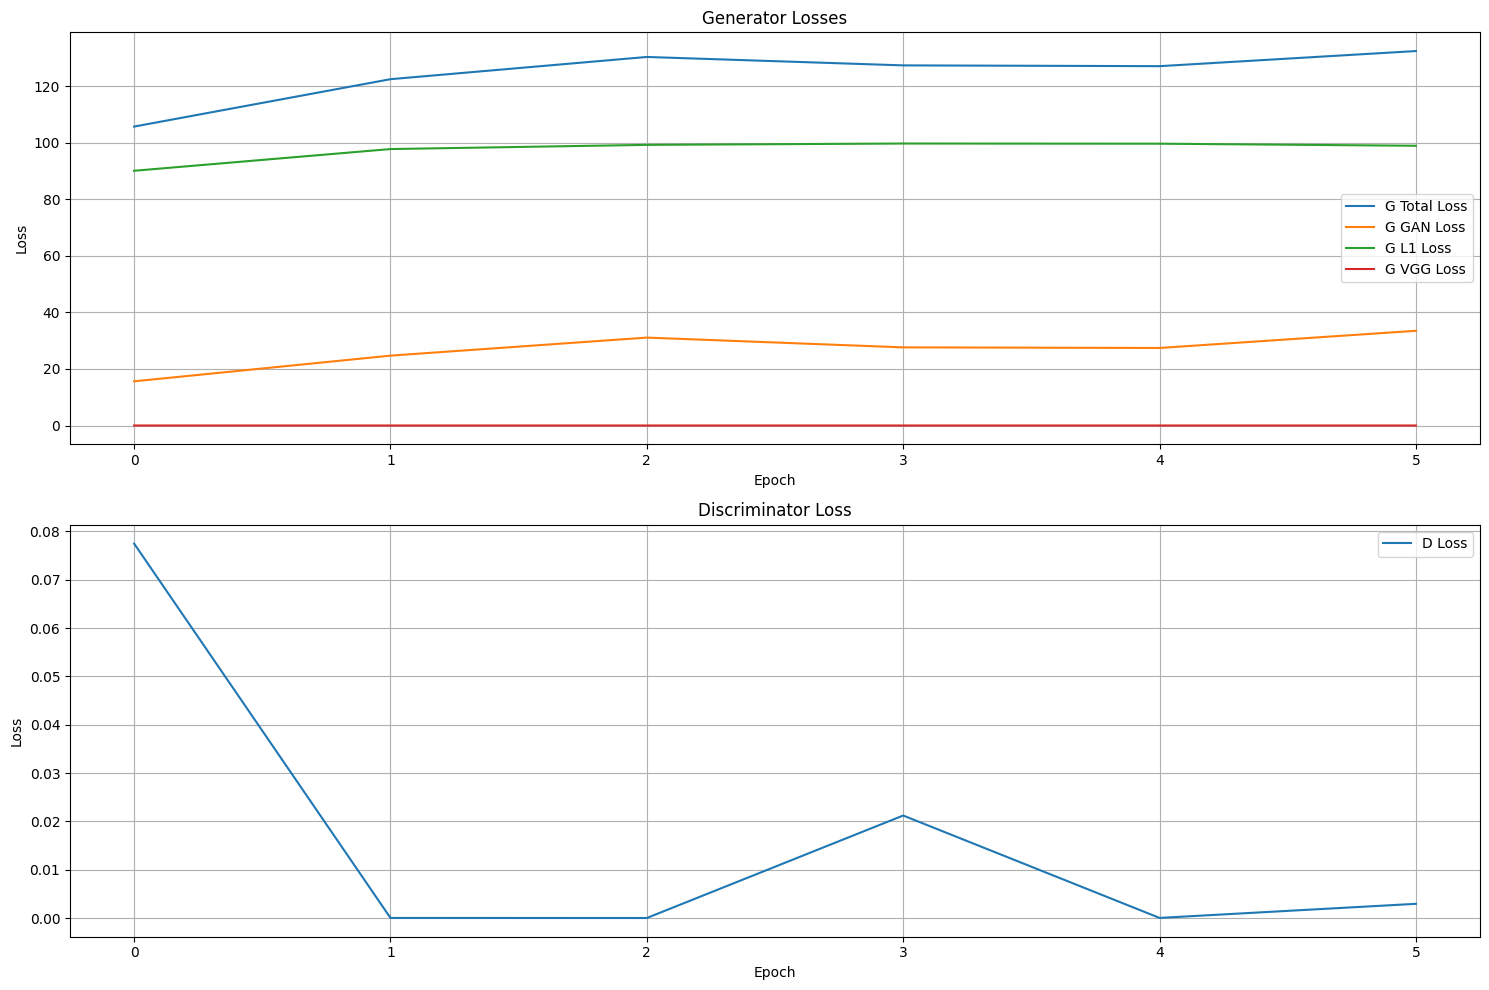

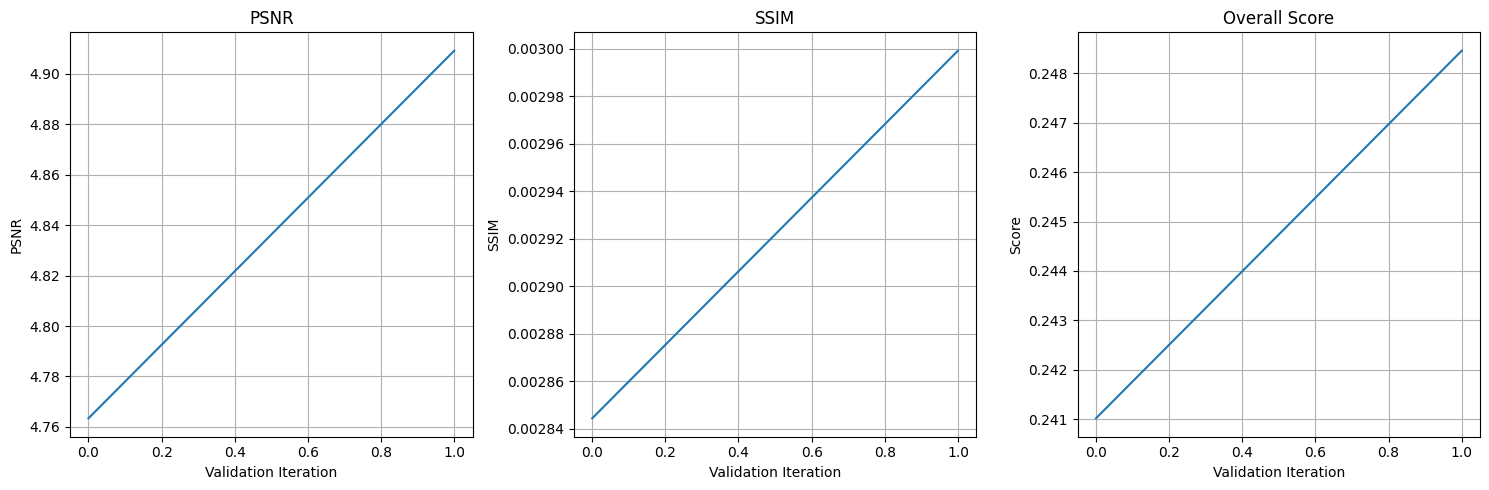

In [8]:
# Fixed cell 6
# Visualize results
dehaze_gan.plot_losses()
dehaze_gan.plot_metrics()

In [9]:
dehaze_gan.inference(test_dataloader)

Inference:   0%|          | 0/500 [00:00<?, ?it/s]

Test Results - PSNR: 4.8250, SSIM: 0.0030, Score: 0.2442


(4.824990970827623, 0.0029588587668695253, 0.2442084073082507)

In [ ]:
# New cell for visualizing random test images
def visualize_test_results(model, test_dataloader, num_samples=5):
    """
    Visualize random test images with their dehazed versions and ground truth
    """
    model.generator.eval()
    
    # Get a list of random indices
    total_samples = len(test_dataloader.dataset)
    random_indices = random.sample(range(total_samples), num_samples)
    
    # Create a figure
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4*num_samples))
    
    with torch.no_grad():
        for i, idx in enumerate(random_indices):
            # Get the sample
            sample = test_dataloader.dataset[idx]
            hazy_img = sample['hazy'].unsqueeze(0).to(device)
            gt_img = sample['gt'].unsqueeze(0).to(device)
            filename = sample['filename']
            
            # Generate dehazed image
            dehazed_img = model.generator(hazy_img)
            
            # Convert to numpy for visualization
            hazy_np = ((hazy_img[0] + 1) / 2).clamp(0, 1).cpu().permute(1, 2, 0).numpy()
            dehazed_np = ((dehazed_img[0] + 1) / 2).clamp(0, 1).cpu().permute(1, 2, 0).numpy()
            gt_np = ((gt_img[0] + 1) / 2).clamp(0, 1).cpu().permute(1, 2, 0).numpy()
            
            # Calculate metrics
            psnr = compare_psnr(gt_np, dehazed_np, data_range=1.0)
            
            # Calculate SSIM with proper parameters
            h, w, c = dehazed_np.shape
            win_size = min(7, h-1, w-1)
            if win_size % 2 == 0:  # Ensure win_size is odd
                win_size -= 1
            win_size = max(3, win_size)
            
            ssim_val = ssim(
                gt_np, 
                dehazed_np, 
                data_range=1.0, 
                channel_axis=2,
                win_size=win_size
            )
            
            # Display images
            axes[i, 0].imshow(hazy_np)
            axes[i, 0].set_title(f"Hazy Image: {filename}")
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(dehazed_np)
            axes[i, 1].set_title(f"Dehazed Image (PSNR: {psnr:.2f}, SSIM: {ssim_val:.4f})")
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(gt_np)
            axes[i, 2].set_title("Ground Truth")
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('test_samples_comparison.png')
    plt.show()
    model.generator.train()

# Visualize 5 random test images
visualize_test_results(dehaze_gan, test_dataloader, num_samples=5)

In [10]:
import shutil

# Change 'your-folder-path' to the actual dataset path in Kaggle
folder_path = "/kaggle/working/results"
output_zip = "/kaggle/working/reside-6k.zip"

# Zip the folder
shutil.make_archive(output_zip.replace(".zip", ""), 'zip', folder_path)

print(f"Zipped dataset saved at: {output_zip}")


Zipped dataset saved at: /kaggle/working/reside-6k.zip
